<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>

Георгий, доброго дня! рад приветствовать тебя)<br />
<br />
Меня зовут Николай Шавлюго. <br />И на этом этапе твоего движения к новой профессии от меня будут комментарии по написанному коду. <br />Чтобы меньше "мусорить эфир" и чтобы максимально наглядно отделяться от основного кода, есть предложение условиться в некоторых обозначениях:<br /> <br />
<u><b>ТАКОЙ ШРИФТ</b></u> - всегда начало комментария <br />
<font color='green'>такой шрифт</font> - комментарии о том, что всё ОК <br/>
<font color='orange'>такой шрифт</font> - комментарии о том, что всё ОК по результату,<br> однако есть на что обратить внимание в плане применения техник, или есть способы сделать более короткий или быстрый код <br/>
<font color='red'>такой шрифт</font> - комментарии о том, что есть критичный момент, влияющий на бизнес-результат проекта.<br/>
</font><br /><br />
<font color='green'>Моей целью является не "уличить" в не знании, а просто высказать сверху твоих знаний - свой опыт, что бы ты мог использовать его для своего дальнейшего успеха) И очень здорово будет, если тебе удастся задавать вопросы, да и вообще - всячески доставать меня, если я по каким-то причинам не приму проект:) При этом, из своего опыта скажу, хорошо и важно, когда переписка ревьюера и студента - сохраняется на следующие проекты и даже на будущую практическую деятельность.<br>
<br> Я сразу же начал общаться на ты:) но если это не очень удобно, то дай знать)) <BR> В ПУТЬ!<br>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Николай, привет! Комментарии по тексту буду писать вот на таком фоне
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>Привет Георгий! Ок, понял) Пошёл смотерть...

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Предварительная подготовка

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display_html
from itertools import chain,cycle
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import gc
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from warnings import filterwarnings
filterwarnings("ignore")
pd.options.display.max_colwidth = 999

In [2]:
GLOBAL_RANDOM_STATE=12345

In [3]:
# вывод статистики с более информативной визуализацией
def frame_info(df, nans_bar=True): 
    frame = df\
    .isna()\
    .sum()\
    .to_frame(name='Nans')\
    .assign(Nans_share = lambda data: data['Nans'] / df.shape[0])\
    .join(df.count().rename('Non-Nans'), how='inner')\
    .assign(Type = df.dtypes)\
    .sort_values(by='Nans')\
    [['Non-Nans','Nans','Nans_share','Type']]
    return frame\
            .style\
            .bar(subset=['Nans_share'],color='lightblue') if nans_bar else frame
    

In [4]:
# отобразить несколько фреймов рядом
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h3>{title}</h3>'
        html_str+=df.to_html().replace('table','table style="display: inline; "')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [5]:
# построение boxplot для нескольких одноколоночных датафреймов
def boxplot(onecolumn_frames_list=[], xlab='', ylab='', title='', vert=False, figsize=(10,5), fontsize=12, showfliers=True, notch=False):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    series_list, legend_list, lowers, uppers = [], [], [], []
    label_info = ""
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
        q1 = i[column_name].quantile(0.25)
        q3 = i[column_name].quantile(0.75) 
        iqr = q3 - q1
        median = i[column_name].median()
        mean = i[column_name].mean()
        lower = q1 - 1.5*iqr
        if lower < 0:
            lower = 0
        upper = q3 + 1.5*iqr   
        lowers.append(lower)
        uppers.append(upper)
        label_info += f"\n {column_name}: границы усов = [{round(lower,2)}; {round(upper,2)}], среднее = {round(mean,2)}, медиана = {round(median,2)}, Q1 = {round(q1,2)}, Q3 = {round(q3,2)}" 
        
    bp = ax.boxplot(
        series_list,
        vert=vert,
        patch_artist=True,
        labels=legend_list,
        showfliers=showfliers,
        notch=notch, 
        sym='gs'
    )
    
    colors = ['lightblue', 'lightgreen', 'orange', 'pink', 'yellow','red', 'black', 'green', 'grey', 'blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
        
    if vert == False: 
        ax.xaxis.grid(True)
    else: 
        ax.yaxis.grid(True)
        
    ax.set_title(title)
    ax.set_xlabel(xlab + label_info)
    
    ax.set_ylabel(ylab)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()

In [6]:
# восстанавливаем значения по моде, получая значения моды для столбца из данных группировки по иным столбцам
def resurrect_by_mode(data: pd.DataFrame, rgroup: list, rtarget: str) -> pd.DataFrame:
    known = data[rgroup + [rtarget]]\
        .dropna()\
        .groupby(by=rgroup)[rtarget]\
        .agg(pd.Series.mode)\
        .reset_index()\
        .merge(data,how='right', on=rgroup)   
    known[rtarget +'_x'] = known[rtarget + '_x'].apply(lambda x: np.NaN if type(x) == np.ndarray else x) # корректировка если pd.Series.mode вернула пустой pd.Series
    index = known[known[rtarget +'_y'].isna()].index
    for i in index: 
        known.at[i, rtarget + '_y'] = known.at[i, rtarget + '_x'] 
    known.rename(columns={rtarget + '_y': rtarget},inplace=True)
    known.drop(rtarget + '_x', axis=1,inplace=True)
    return known    

In [7]:
# построение гистограм для одного и более фреймов
def hist(onecolumn_frames_list=[], xlab='', ylab='', title='', bins=10, xrange=None, yrange=None, figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    rmin, rmax = 999999999999999, 0
    series_list, legend_list = [], []
    alpha, alpha_step = 1, int((40 / len(onecolumn_frames_list))) / 100 # полная прозрачность нам не нужна 
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
    for i in series_list:
        rmin = i.min() if i.min() < rmin else rmin
        rmax = i.max() if i.max() > rmax else rmax
        ax.hist(i,bins=bins, alpha=alpha)
        alpha -= alpha_step
    rrange = xrange if xrange != None else (rmin,rmax)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(rrange)
    if yrange != None:
        ax.set_ylim(yrange)
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    plt.grid()
    fig.tight_layout()

In [8]:
# общий класс для проведения исследований 
class Comparator:
    # переинициализация 
    def _reset(self):
        # перечень моделей и их гиперпараметров для перебора
        self.estimators = { 
            'LinearRegression': {
                'estimator': LinearRegression(),
                'grid': {
                    'fit_intercept': [True, False],
                    'normalize': [True, False]
                },
            },
            'RandomForestRegressor': {
                'estimator': RandomForestRegressor(),
                'grid': {
                    'n_estimators': [11, 29, 43],
                    'max_depth': [2, 3, 5],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                },
            },
            'LGBMRegressor': {
                'estimator': LGBMRegressor(),
                'grid': {
                    'n_estimators': [11, 29, 43],
                    'max_depth': [2, 3, 5],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                }
            },   
            'CatBoostRegressor': {
                'estimator': CatBoostRegressor(),
                'grid': {
                    'verbose': [False],
                    'n_estimators': [11, 29, 43],
                    'learning_rate': [0.3, 0.6, 0.9],
                    'random_state': [GLOBAL_RANDOM_STATE]                
                }
            },   
        }
        
    # расчет качества: единая точка, чтобы можно было легко изменить по ходу работы
    @staticmethod
    def _error(targ, targ_pred):
        error = mean_squared_error(targ, targ_pred) ** 0.5 # rmse
        return error

    # сравнение алгоритмов
    def process(self, 
                    ufeat_train: pd.DataFrame, utarg_train: pd.Series, 
                    ufeat_test: pd.DataFrame, utarg_test: pd.DataFrame,
                    feat_categorial: list,
                    feat_numeric: list,
                    activate: list = None) -> None:
        start_time = time.perf_counter()
        self._reset()
        feat_train = ufeat_train.copy().reset_index(drop=True)
        feat_test = ufeat_test.copy().reset_index(drop=True)
        targ_train = utarg_train.copy().reset_index(drop=True);
        targ_test = utarg_test.copy().reset_index(drop=True);   
        
        feat_train_scaled, feat_test_scaled = self._scale(feat_train, feat_test, feat_numeric)
        feat_train, feat_test = self._encoding(feat_train_scaled, feat_test_scaled, feat_categorial)

        self.feat_train = feat_train
        self.feat_test = feat_test
    
        for estimator_name in self.estimators:
            estimator = self.estimators[estimator_name]['estimator']
            if activate != None:
                if not estimator_name in activate:
                    continue
            self._gridsearch_wrapper(estimator,
                                     feat_train,
                                     targ_train,
                                     feat_categorial,
                                     feat_numeric)

            self._predict_and_score(estimator, feat_train, targ_train, 'pred_train', 'pred_score_train','pred_time_train')
            self._predict_and_score(estimator, feat_test, targ_test, 'pred_test', 'pred_score_test','pred_time_test') 
            
        end_time = time.perf_counter()
        print('Общее время:', (end_time-start_time))
        
        
    def _gridsearch_wrapper(self,
                            estimator,
                            feat_train: pd.DataFrame,
                            targ_train: pd.DataFrame,
                            feat_categorial: list,
                            feat_numeric: list):
        self._gridsearch(estimator, feat_train, targ_train)    
        
    # масштабирование
    def _scale(self, feat_train: pd.DataFrame, feat_valid: pd.DataFrame, feat_numeric: list) -> list:
        scaler = StandardScaler()
        scaler.fit(feat_train[feat_numeric])
        feat_train[feat_numeric] = scaler.transform(feat_train[feat_numeric])
        feat_valid[feat_numeric] = scaler.transform(feat_valid[feat_numeric])
        return [feat_train, feat_valid]        

    # ohe
    def _encoding(self, feat_train: pd.DataFrame, feat_valid: pd.DataFrame, feat_categorial: list) -> list:
        feat_train = pd.get_dummies(feat_train, drop_first=True, columns=feat_categorial)
        feat_valid = pd.get_dummies(feat_valid, drop_first=True, columns=feat_categorial)
        return [feat_train, feat_valid]        
    
    
    # предсказания с лучшими параметрами и расчет метрики 
    def _predict_and_score(self,
                           estimator,
                           feat: pd.DataFrame, 
                           targ: pd.Series, 
                           pred_key: str, 
                           score_key: str,
                           pred_time_key: str) -> None:
            estimator_name = estimator.__class__.__name__
            start_time = time.perf_counter()
            pred = self.estimators[estimator_name]['best'].predict(feat)
            end_time = time.perf_counter()
            self.estimators[estimator_name][pred_key] = pd.Series(pred)
            self.estimators[estimator_name][score_key] = Comparator._error(targ, pred)
            self.estimators[estimator_name][pred_time_key] = round(end_time-start_time, 3)
            
        
    # подбор гиперпараметров и сохранение лучшей модели для каждого конкретного алгоритма
    def _gridsearch(self, estimator: object, feat: pd.DataFrame, targ: pd.Series) -> None:
        start_time = time.perf_counter()
        estimator_name = estimator.__class__.__name__
        gscv = GridSearchCV(
                estimator,
                self.estimators[estimator_name]['grid'],
                scoring=make_scorer(Comparator._error, greater_is_better=False),
                cv=3,
                verbose=0,
                return_train_score=True,
                refit=True,
                n_jobs=4
        )
        gscv.fit(feat, targ)
        end_time = time.perf_counter()
        timedelta = round(end_time-start_time,3)
        self.estimators[estimator_name]['params'] = gscv.best_params_
        self.estimators[estimator_name]['score'] = gscv.best_score_ * (-1)
        self.estimators[estimator_name]['best'] = gscv.best_estimator_
        self.estimators[estimator_name]['time_fit'] = timedelta
        print('Выбор гиперпараметров', estimator_name,'занял',"{:.3f}".format(timedelta), 'секунд')
            
    # сводный отчет о результатах
    def report(self):
        frame = pd.DataFrame(
            { 
                "Estimator": [], 
                "Лучшие параметры": [], 
                "CV-RMSE (train)": [],
                "RMSE (train)": [],
                "RMSE (test)": [],
                "Time (fit)": [],
                "Time (predict, train)": [],
                "Time (predict, test)": []
            })
        for estimator_name in self.estimators:
            if 'best' in self.estimators[estimator_name]:
                frame.loc[len(frame)] = [
                    estimator_name,
                    self.estimators[estimator_name]['params'], 
                    self.estimators[estimator_name]['score'], 
                    self.estimators[estimator_name]['pred_score_train'], 
                    self.estimators[estimator_name]['pred_score_test'], 
                    self.estimators[estimator_name]['time_fit'], 
                    self.estimators[estimator_name]['pred_time_train'], 
                    self.estimators[estimator_name]['pred_time_test']
                ]
        return frame
            
    def predictions(self, classname: str) -> list:
        for estimator in self.estimators:
            if estimator.__class__.__name__  == classname:
                result = {
                    'pred_train': self.estimators[estimator]['pred_train'], 
                    'pred_test': self.estimators[estimator]['pred_test'] 
                }
                return result
        return None
    
    # масштабированные feature_impotrances во всех best models
    def scaled_feature_importances(self, round_digits=3, sort_ascending=False) -> pd.DataFrame:
        scaled_feature_importances = pd.DataFrame(columns=self.feat_train.columns)
        for estimator_name in self.estimators:
            estimator = self.estimators[estimator_name]['best']
            if hasattr(estimator,'feature_importances_'):
                scaled_feature_importances.loc[estimator_name] = estimator.feature_importances_
        scaler = MinMaxScaler()
        transposed = scaled_feature_importances.transpose()
        transposed_scaled_feature_importances = pd.DataFrame(
                                                    scaler.fit_transform(transposed),
                                                    columns=transposed.columns, 
                                                    index=transposed.index)
        cols = list(transposed_scaled_feature_importances.columns.values)
        return transposed_scaled_feature_importances\
                .apply(lambda x: round(x, round_digits))\
                .sort_values(by=cols, ascending=sort_ascending)          

In [9]:
# barchart с горизонтальной раскладкой
def barchart(df: pd.DataFrame, xlabel='', ylabel='', title='', xrange=(0,1), yrange=None, figsize=(10,5), fontsize=12, grid_axis='x'):
    plt.rcdefaults()
    plt.rcParams.update({'font.size': fontsize})
    dft = df.transpose()

    size = len(dft.values)
    full_height = 1
    intercol_height = 0.1
    height = full_height / size 
    y = []
    for i in range(len(dft.columns), 0, -1):
        y.append(i * (full_height + intercol_height) + intercol_height)
    y = np.array(y)
    fig, ax = plt.subplots()
    for i in range(size):
        bar = ax.barh(y + i * height, dft.values[i], height, label=dft.index.values[i])
        # ax.bar_label(bar, padding=2) # только с версии 3.4 matplotlib

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_yticks(y - height/2 + size*height/2)
    ax.set_yticklabels(dft.columns)
    ax.legend()

    fig.set_size_inches(figsize)
    plt.grid(axis=grid_axis)    
    fig.tight_layout()
    plt.show()

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u><br>
<font color='green'>Достойный арсенальчик!

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Накопленный код из предыдущих проектов с некоторыми модификациями
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>)

## Подготовка данных

In [10]:
data = pd.read_csv('/datasets/autos.csv')

In [11]:
frame_info(data)

,Non-Nans,Nans,Nans_share,Type
DateCrawled,354369,0,0,object
Price,354369,0,0,int64
RegistrationYear,354369,0,0,int64
Power,354369,0,0,int64
Kilometer,354369,0,0,int64
RegistrationMonth,354369,0,0,int64
Brand,354369,0,0,object
DateCreated,354369,0,0,object
NumberOfPictures,354369,0,0,int64
PostalCode,354369,0,0,int64


In [12]:
data.sample(5, random_state=GLOBAL_RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46


In [13]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u><br />
<font color='green'>ОК, данные на базе)

Подробнее: **DateCrawled**, **DateCreated**, **LastSeen**, **RegistrationYear** и **RegistrationMonth**

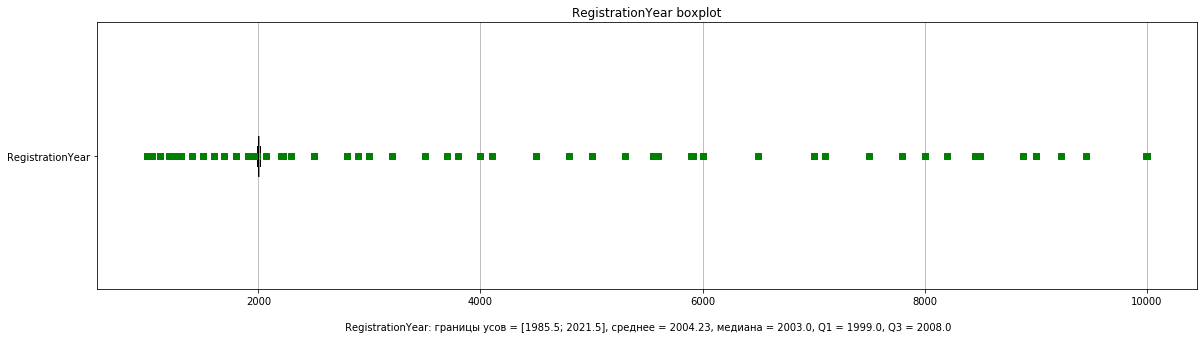

In [14]:
boxplot(
        [data[['RegistrationYear']]],
        figsize=(17,5), 
        fontsize=16,
        title=f'RegistrationYear boxplot'
) 

Удалим всю "явную фантастику", т.е. автомобили, имеющие RegistrationYear > 2022 года (данную работу мы пишем в 2021):

In [15]:
data = data.query('RegistrationYear <= 2022')

В прошлом тоже ошибки: как известно (https://ru.wikipedia.org/wiki/История_автомобиля) Бенц создал первый автомобиль в 1885. Вряд ли он вообще попадает в нашу выборку, но все же:

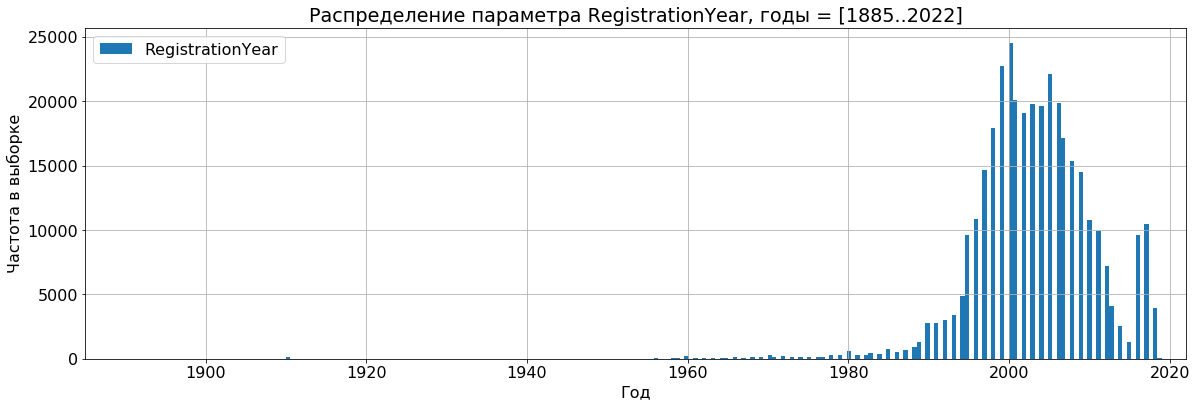

In [16]:
hist(
        onecolumn_frames_list = [data[['RegistrationYear']].query('1885 <= RegistrationYear <= 2022')],
        xlab='Год',
        ylab='Частота в выборке',
        title='Распределение параметра RegistrationYear, годы = [1885..2022]',
        fontsize=18,
        bins=200,
        figsize=(17,6),
        xrange=(1885, 2022)
    )

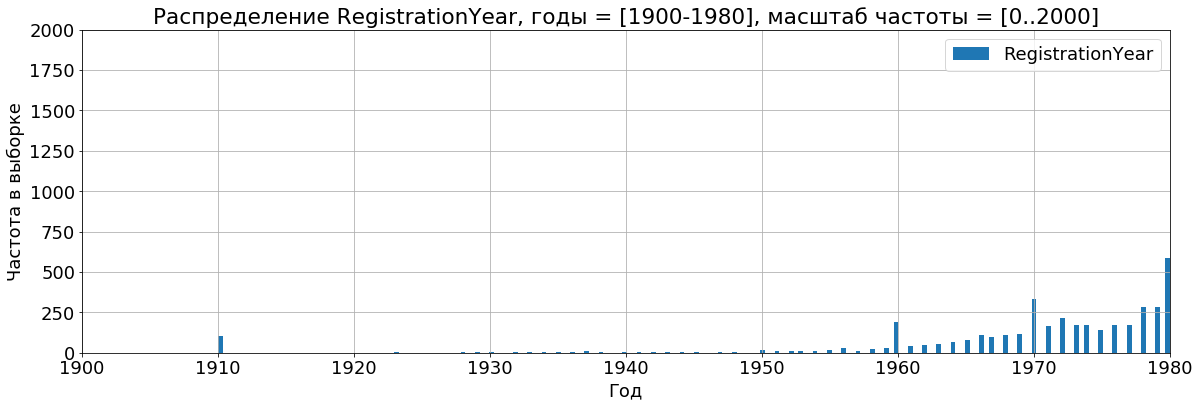

In [17]:
hist(
        onecolumn_frames_list = [data[['RegistrationYear']].query('1900 <= RegistrationYear <= 1980')],
        xlab='Год',
        ylab='Частота в выборке',
        title='Распределение RegistrationYear, годы = [1900-1980], масштаб частоты = [0..2000]',
        fontsize=18,
        bins=200,
        figsize=(17,6),
        xrange=(1900, 1980),
        yrange=(0,2000)
    )

Отбросим все, что было зарегистрировано ранее 1950, т.к. незначимо по количеству + это явно отдельный рынок даже не "ретро-авто", а "музейных экспонатов":

In [18]:
data = data.query('RegistrationYear > 1950')

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
Отличное исследование (вместе с ссылкой на источник данных!)<br>
Есть пару моментов на обсуждение:<br>
1) последняя дата регистрации на сайте - 2016 год. Значит всё что больше 2016 - аномалии..<br>
2) нижняя отсечка 1950: Полностью согласен, что до того времени совсем иное ценнообразование у машин, ОК. Если в целом, то тут с бизнесом можно пообщаться на предмет - какие машины на сервисе будут. Ретро, супер ретро, люьые или только не старше 40 , например. Ну и исходя из этого - выставлять отсечку....

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
    
1. Да, я тоже изначально так думал. Потом пришел к тому, что у нас - "датасет с особенностями". Но даже без гипотезы "данные о годе регистрации могли обновить после скачиваения", допустима ситуация, когда "купил машину под продажу, она к тебе едет, но ты ее уже выставил на сайте и планируешь зарегистрировать в будущем". Здесь действительно - поможет только "понимание от бизнеса"
1. Давай  посмотрим на вопрос "совсем серьезно", а не просто "отсечкой": у нас 300K строк, мы можем смело "брать максимально узкие срезы" и учить регрессию на них; с учетом того, что даже в этих срезах будет много данных (тысячи или даже десятки тысяч для популярных машин), "специализированная регрессия" **скорее всего** будет многократно точнее "обобщенной"
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>согласен, можно взять узкие интерваы в разрезе сегмента авто (старая, ретро...)

Изучение registrationMonth вызывает две гипотезы:
1. Данные являются сводов из нескольких баз, в части из которых месяц задается как 0..11, а в части - как 1..12
1. Возможно, указывали 0, когда не знали или не хотели указывать месяц регистрации, а 1..12 - номера месяцев (наиболее вероятно)

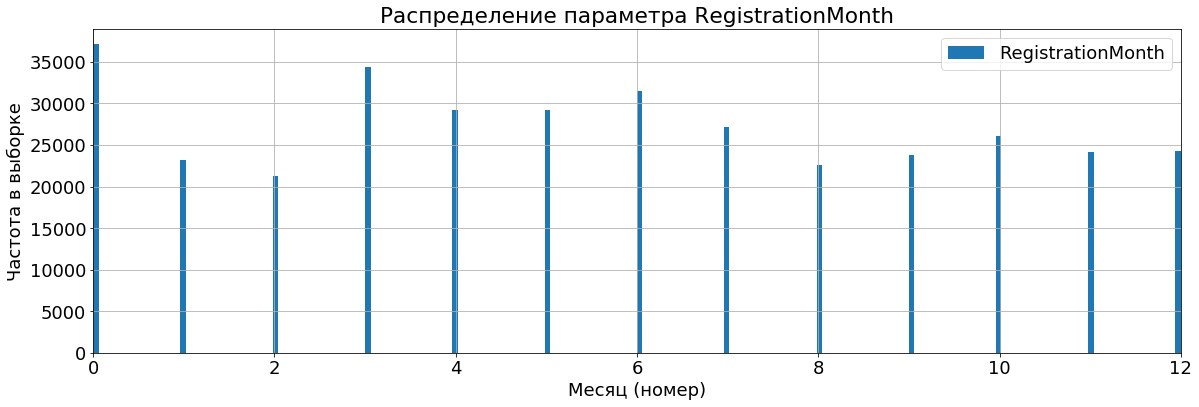

In [19]:
hist(
        onecolumn_frames_list = [data[['RegistrationMonth']]],
        xlab='Месяц (номер)',
        ylab='Частота в выборке',
        title='Распределение параметра RegistrationMonth',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )

Поскольку, мы ограничились 1950-ым в качестве RegistrationYear, можно легко заменить пару RegistrationYear и RegistrationMonth на хороший (сравнимый) численный признак RegMonthsFrom1950 (хотя тут мы несколько "размываем" признак, что может сказаться на результате):

In [20]:
data['RegMonthsFrom1950'] = 12 * (data['RegistrationYear'] - 1950) + data['RegistrationMonth']

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
Тут, скорее, можно месяц отбросить. На цену больше влияет именно возраст (год регистрации). Но попробовать можно и это признак.

Создадим datetime-признаки для удобства дополнительного форматного контроля:

In [21]:
data['DateCrawledDT'] = data['DateCrawled'].astype('datetime64')
data['DateCreatedDT'] = data['DateCreated'].astype('datetime64')
data['LastSeenDT'] = data['LastSeen'].astype('datetime64')

Чего мы **не ожидаем**? Например, того, что DateCreated будет больше DateCrawled, и это верно:

In [22]:
data.query('DateCreatedDT > DateCrawledDT')['DateCreated'].count()

0

Мы также вправе ожидать, что LastSeen всегда меньше DateCrawled ... **но это неверно**:

In [23]:
data.query('DateCreatedDT < LastSeenDT')['LastSeen'].count()

354000

Т.е. информация о последней активности пользователя поступает к нам **после** того, как мы скачали анекту. Ok, сформируем хороший численный признак, например DaysOnSale, как разность между датой создания объявдения и последней активностью пользователя (используем "слабую" гипотезу "один пользователь продает только один автомобиль и перестает посещать сайт после продажи", но будем считать ее верной):

In [24]:
data['DaysOnSale'] = (data['LastSeenDT'] - data['DateCreatedDT']).dt.days

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
ОК, здорово проверил всё)

В завершении, удалим бессмысленный с точки зрения определения цены DateCrawled и первичные признаки (как зависимые):

In [25]:
data = data.drop(
    columns=[
        'LastSeenDT',
        'LastSeen',
        'DateCrawledDT',
        'DateCrawled',
        'DateCreatedDT',
        'DateCreated',
        'RegistrationYear',
        'RegistrationMonth']
    )

<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
Как вараинт - ОК. Ещё можно почтовый код (слишком много категорий, прсто набор цифр) и "количесвто фото" (константа)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Не соглашусь с почтовым кодом: давай мысленно сравним цели на японские машины в Москве и Владивостоке и "почувствуем разницу". Почтовый код <b>скорее всего</b> - признак с высоким уровнем значимой информации (хотя работа с ним затруднена из-за невозможности хорошей группировки хотя бы по региону - у нас в базе разные коды ранзных форматов), но другое дело - техническая возможность работы с ним (в итоге и не работаю с ним из-за памяти)    
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>ок, ниже как раз оставлял предложение, как гипотезу, что можно от кода можно поиспользовать пару первых цифр. Тогда категории будут более рельефные и в модели будут "играть" интереснее)

In [26]:
frame_info(data)

,Non-Nans,Nans,Nans_share,Type
Price,354000,0,0,int64
Power,354000,0,0,int64
Kilometer,354000,0,0,int64
Brand,354000,0,0,object
NumberOfPictures,354000,0,0,int64
PostalCode,354000,0,0,int64
RegMonthsFrom1950,354000,0,0,int64
DaysOnSale,354000,0,0,int64
Model,334466,19534,0.0551808,object
Gearbox,334403,19597,0.0553588,object


Подробнее: **Price**

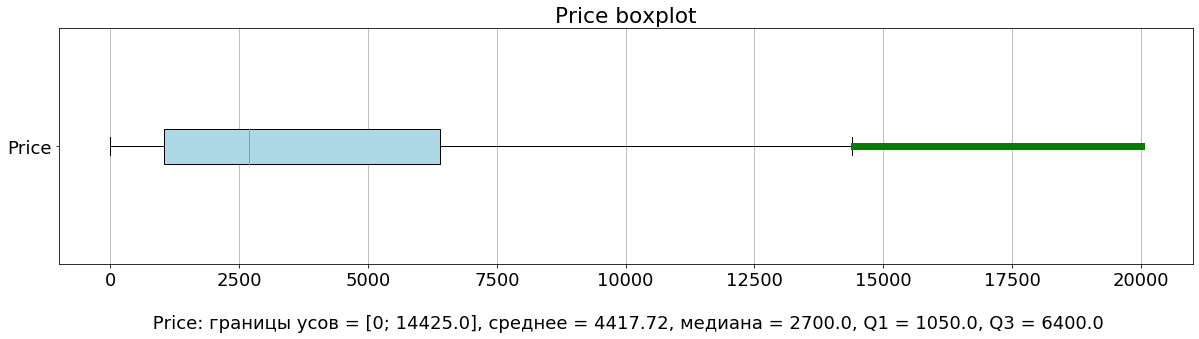

In [27]:
boxplot(
        [data[['Price']]],
        figsize=(17,5), 
        fontsize=16,
        title=f'Price boxplot'
) 

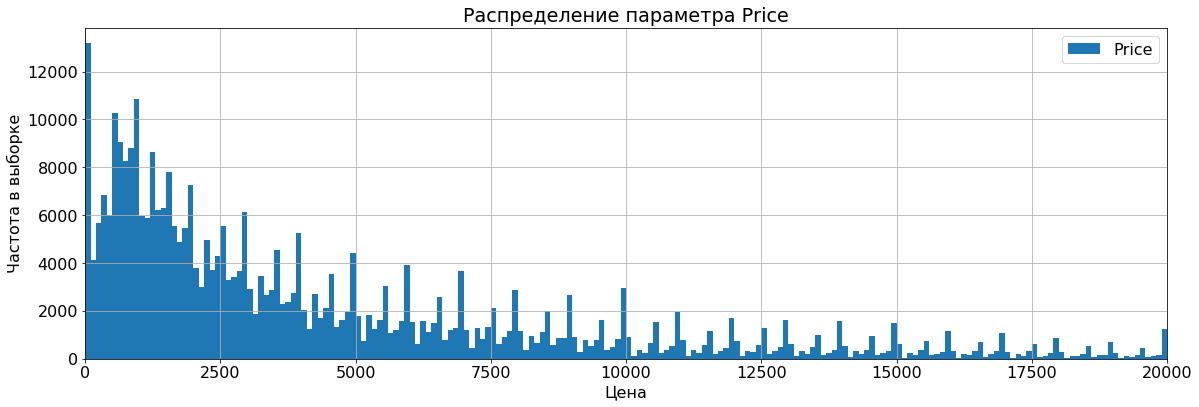

In [28]:
hist(
        onecolumn_frames_list = [data[['Price']]],
        xlab='Цена',
        ylab='Частота в выборке',
        title='Распределение параметра Price',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )

Да, люди любят "круглые цифры" (как и деньги в целом). Ничего интересного, кроме большого количества дешевых авто:

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
:)

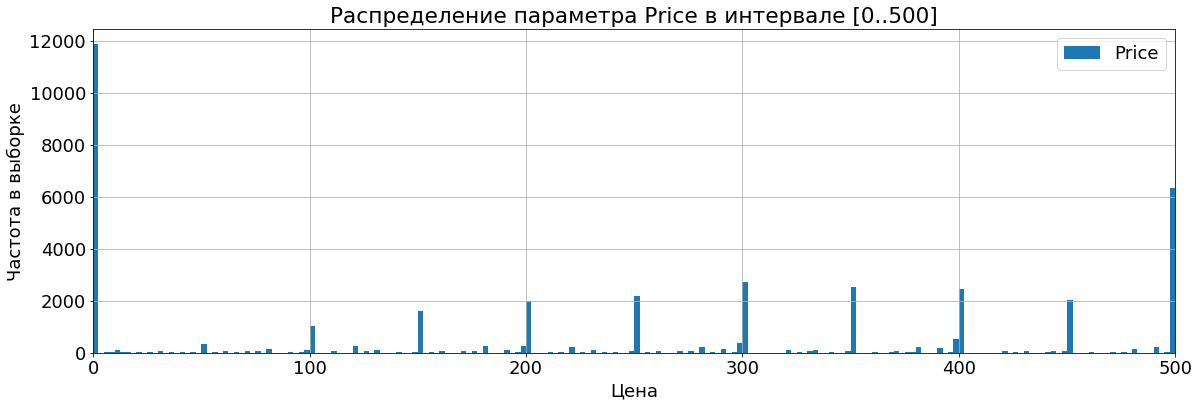

In [29]:
hist(
        onecolumn_frames_list = [data[['Price']].query('0 <= Price <= 500')],
        xlab='Цена',
        ylab='Частота в выборке',
        title='Распределение параметра Price в интервале [0..500]',
        fontsize=18,
        bins=200,
        xrange=(0,500),
        figsize=(17,6)
    )

Автохлам? Может, и даром отдают? Да, и это большая часть при Price < 100:

In [30]:
data[['Brand','Model','Price']].query('Price == 0')

,Brand,Model,Price
7,volkswagen,other,0
40,opel,corsa,0
111,volkswagen,golf,0
115,volkswagen,NaN,0
152,opel,meriva,0
...,...,...,...
354205,opel,corsa,0
354238,ford,fiesta,0
354248,suzuki,swift,0
354277,seat,arosa,0


Мы не будем ничего с этим делать (хотя и могли бы применить разные техники восстановления или удалить), т.к:
1. это целевой признак 
1. сценарий "отдам хлам самовывозом" вполне реалистичен

<div style="background: #ffeeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
Аргумент, ок. С другой стороны, мы хоти делать бизнес, т.е. нам интересны те машины, которые продаются за деньги. Тут, всё-таки, логичнее брать только их. Но это моё мнение)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>Есть таой ещё подход для работы с количественными данными: совместно со статистическим анализом проводить бизнес-анализ данных. Т.е. подключать понимание рынка и на этом понимании устанавливать отсечки. И также,оставлять ссылки на источник знаний по границам отсечек, чтобы это не выглядело, будто бы решение принимал аналитик исключительно от себя)

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Надо попросить Яндекс.Практикум к наставникам, проверяющим и кураторам нанять еще и бизнес-консультантов ;)
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>И вместе обсудить за бокалом чая:) <br>

Подробнее: **NotRepaired**

In [31]:
data['NotRepaired'].value_counts()

no     247098
yes     36025
Name: NotRepaired, dtype: int64

Восстановления здесь быть не может (это независимая переменная по любой из возможных групп в данных), но, очевидно, нужна третья категория: "информация недоступна", которая наиболее близко отражает физическую суть "кто-то решил не указывать сведения":

In [32]:
data['NotRepaired'] = data['NotRepaired'].apply(lambda x: 'unknown' if x is np.NaN else x)
data['NotRepaired'].value_counts()

no         247098
unknown     70877
yes         36025
Name: NotRepaired, dtype: int64

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>принято) С категориаьными факторами, т.е. пропусками в них: действиетльно, подчас непросто их заполнить. И выход - подстановка новой категории "неизвестно" ("другое") видится оправданным. Или удалить)

In [33]:
frame_info(data)

,Non-Nans,Nans,Nans_share,Type
Price,354000,0,0,int64
Power,354000,0,0,int64
Kilometer,354000,0,0,int64
Brand,354000,0,0,object
NotRepaired,354000,0,0,object
NumberOfPictures,354000,0,0,int64
PostalCode,354000,0,0,int64
RegMonthsFrom1950,354000,0,0,int64
DaysOnSale,354000,0,0,int64
Model,334466,19534,0.0551808,object


Подробнее: **NumberOfPictures**

In [34]:
data['NumberOfPictures'].value_counts()

0    354000
Name: NumberOfPictures, dtype: int64

А это столбец с нулями, удаляем:

In [35]:
data.drop(columns=['NumberOfPictures'],inplace=True)

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>да, ОК!

In [36]:
frame_info(data)

,Non-Nans,Nans,Nans_share,Type
Price,354000,0,0,int64
Power,354000,0,0,int64
Kilometer,354000,0,0,int64
Brand,354000,0,0,object
NotRepaired,354000,0,0,object
PostalCode,354000,0,0,int64
RegMonthsFrom1950,354000,0,0,int64
DaysOnSale,354000,0,0,int64
Model,334466,19534,0.0551808,object
Gearbox,334403,19597,0.0553588,object


Подробнее: **PostalCode**

Категориальная переменная (численные сравнения бессмысленны) с большим числом значений, где и 4 и 5 цифр допустимы (https://en.wikipedia.org/wiki/List_of_postal_codes):

In [37]:
data['PostalCode'].apply(lambda x: len(str(x))).value_counts()

5    335877
4     18123
Name: PostalCode, dtype: int64

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>да, поэтому можно и удалить.А можно попробовать оставить 1-2 первые цифры от почнового кода... тогда категорий будет меньше. И для модели - уже интереснее.. Но это на будущие исследования)

Подробнее: **Kilometer**

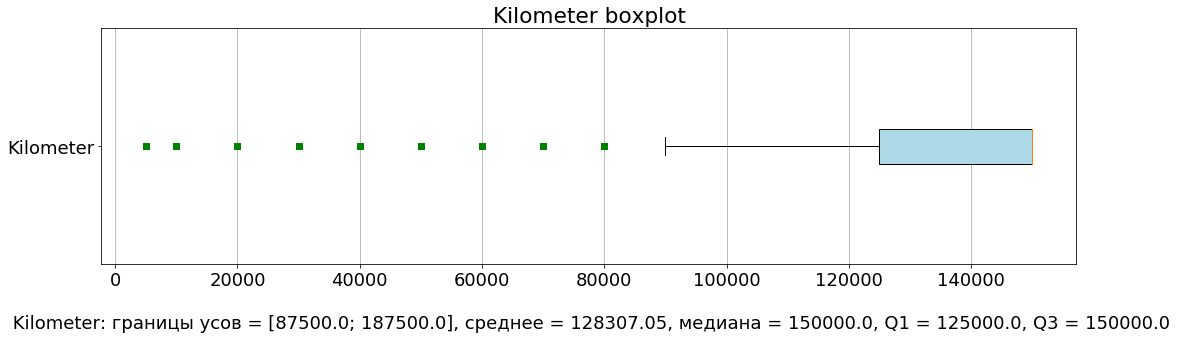

In [38]:
boxplot(
        [data[['Kilometer']]],
        figsize=(17,5), 
        fontsize=16,
        title=f'Kilometer boxplot'
) 

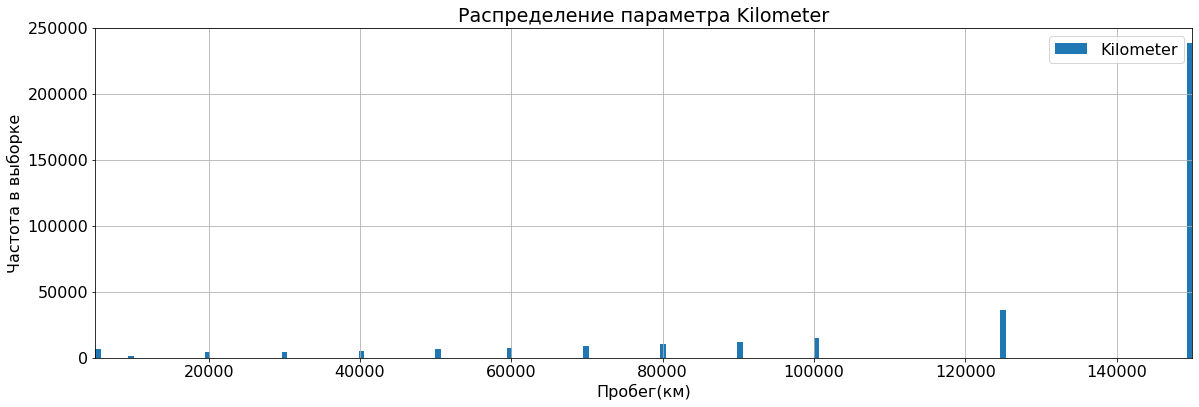

In [39]:
hist(
        onecolumn_frames_list = [data[['Kilometer']]],
        xlab='Пробег(км)',
        ylab='Частота в выборке',
        title='Распределение параметра Kilometer',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )

Предобработанная численная переменная, ничего интересного

Подробнее: собственные характеристики авто - **Power**, **Brand**, **Model**, **Gearbox**, **FuelType**, **VehicleType**

In [40]:
data['Brand'].value_counts()

volkswagen        76954
opel              39891
bmw               36894
mercedes_benz     32027
audi              29445
ford              25155
renault           17920
peugeot           10992
fiat               9632
seat               6905
mazda              5609
skoda              5498
smart              5246
citroen            5139
nissan             4941
toyota             4605
hyundai            3584
sonstige_autos     3273
volvo              3210
mini               3201
mitsubishi         3018
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2309
chevrolet          1748
chrysler           1436
dacia               900
daihatsu            806
subaru              758
porsche             754
jeep                669
trabant             579
land_rover          544
daewoo              542
saab                525
jaguar              505
rover               485
lancia              471
lada                225
Name: Brand, dtype: int64

Все хорошо: приведено к нижнему регистру, чего-то "радикально странного" не наблюдается. Оставляем как есть

In [41]:
data['FuelType'].value_counts()

petrol      216225
gasoline     98704
lpg           5309
cng            564
hybrid         232
other          199
electric        90
Name: FuelType, dtype: int64

Явно налицо терминологическая путаница: gasoline и petrol - это бензин, но в британской и американской версиях наименования (смотрим https://en.wikipedia.org/wiki/Gasoline) + явно хочется сделать признак бинарным ("petrol"/"not petrol"). Но не будем ничего менять: значения есть, какие - не так важно.

In [42]:
data['Gearbox'].value_counts()

manual    268131
auto       66272
Name: Gearbox, dtype: int64

И тут все ожидаемо хорошо (кроме NaN)

In [43]:
data['VehicleType'].value_counts()

sedan          91425
small          79812
wagon          65162
bus            28771
convertible    20191
coupe          16152
suv            11978
other           3264
Name: VehicleType, dtype: int64

И тут хорошо (опять же, кроме NaN)

In [44]:
data['Model'].value_counts()

golf                  29214
other                 24344
3er                   19754
polo                  13061
corsa                 12562
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

Тут (помимо NaN) плохо тем, что при OHE-кодировании может получиться много признаков

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>поэтому, к таким признакоам можно примениять методот ordinal

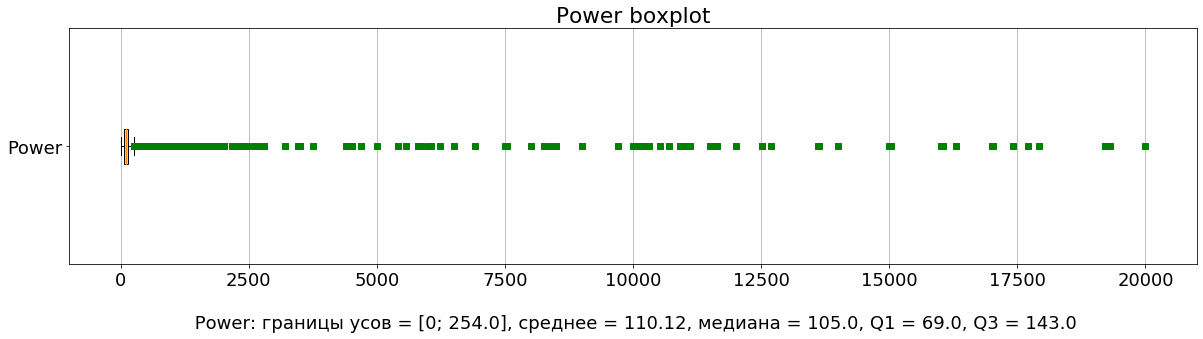

In [45]:
boxplot(
        [data[['Power']]],
        figsize=(17,5), 
        fontsize=16,
        title=f'Power boxplot'
)

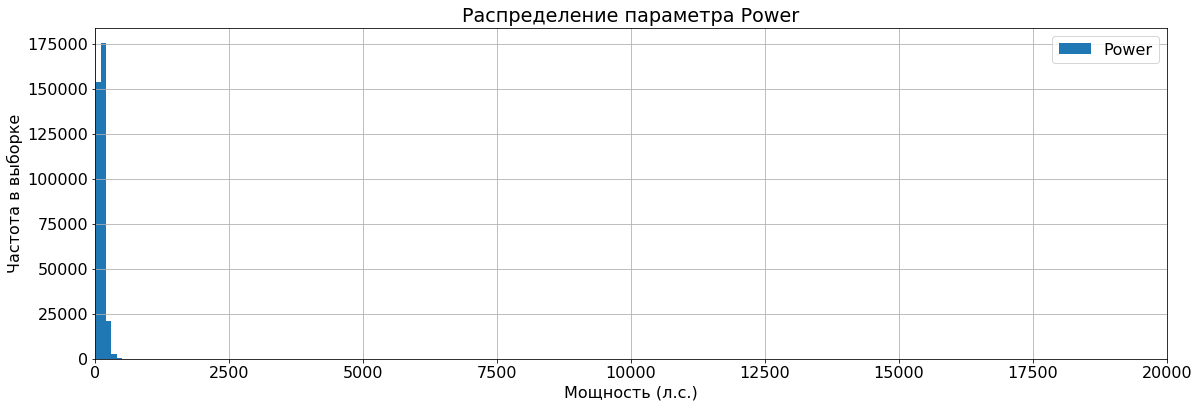

In [46]:
hist(
        onecolumn_frames_list = [data[['Power']]],
        xlab='Мощность (л.с.)',
        ylab='Частота в выборке',
        title='Распределение параметра Power',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )

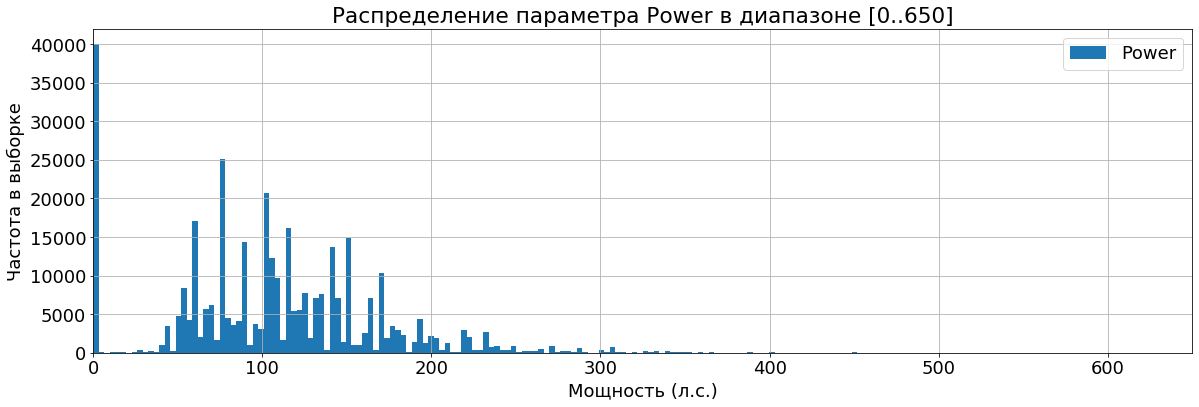

In [47]:
hist(
        onecolumn_frames_list = [data[['Power']].query('0 <= Power <= 650')],
        xlab='Мощность (л.с.)',
        ylab='Частота в выборке',
        title='Распределение параметра Power в диапазоне [0..650]',
        fontsize=18,
        bins=200,
        figsize=(17,6),
        xrange=(0,650)
    )

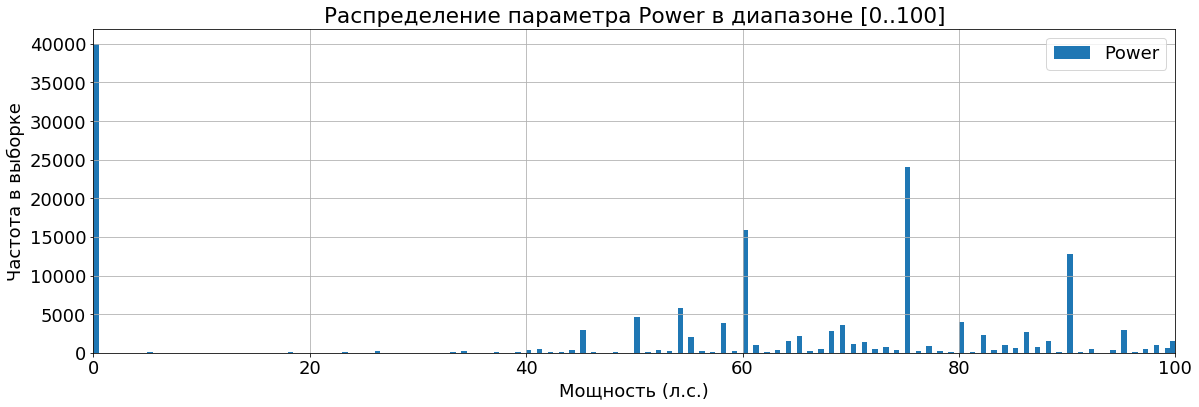

In [48]:
hist(
        onecolumn_frames_list = [data[['Power']].query('0 <= Power <= 100')],
        xlab='Мощность (л.с.)',
        ylab='Частота в выборке',
        title='Распределение параметра Power в диапазоне [0..100]',
        fontsize=18,
        bins=200,
        figsize=(17,6),
        xrange=(0,100)
    )

In [49]:
data[['Power']].query('Power == 0').count()

Power    39960
dtype: int64

Здесь мы отметим только то, что максимальная цена в нашей выборке - 20000 (не важно, долларов, евро или фунтов). Суперкары с мощностью от 1000 л.с. - это существенно более серьезные деньги (на порядки), поэтому, исходя из здравого смысла, можно (в первом приближении) установить их в NaN, равно как и машины с мощностью = 0 л.с (с битым дивгателем? или просто не стали указывать?) + преобразуем в строку чтобы избежать дальнейших затруднений в восстановлении:

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>ок, авто по такой цене стоит смотреть внимательнее или тоже вынести в отдельный кластер, как и ретро.

In [50]:
data['Power'] = data['Power'].apply(lambda x: str(x) if 0 < x < 1000 else np.NaN)

Теперь, используя **моду** по подмножеству признаков, выполним циклическое восстановление собственных признаков авто:

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>лично я сторонник того, что восстанавливать данные моно, когда уверен на 100% в том, что подставляешь. Т.е. уверен, что ошибки не будет. Если такой уверенности нет - удаляю. Но это мой мнение) А твой подход - тоже может быть интересен.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Смотри, здесь логика такая: я оперирую "справочными" свойствами, изначально присущими автомобилю. Я бы мог позвонить на завод и попросить "прислать мне все данные по всем моделям", а потом - вписать вручную и получил бы истину. Но вместо этого, я использую голосование, например: "если <b>большинство</b> пользователей указало, что ['Brand','VehicleType', 'Power', 'Model','Gearbox'] имеют 'FuelType', то я использую именно это значение". Где могуть быть проблемы? Очевидно, в редких машинах, данных по которым мало. Чтобы уйти от этих ошибок, можно ввести "порог голосования" (например, есть минимум 100 строк по срезу) - но, как и Скарлет О'Хара "я подумаю об этом завтра"
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>Так и тут я согласен, просто высказывал именно свой подход) Он мне позволяет не делать проверок подставленных данных, т.е. экономить на этом время:). А любую подстановку надо потом проверять, как она осуществилась...

In [51]:
group = ['FuelType','Brand','VehicleType', 'Power', 'Model','Gearbox']

In [52]:
frame_info(data[group])

,Non-Nans,Nans,Nans_share,Type
Brand,354000,0,0,object
Model,334466,19534,0.0551808,object
Gearbox,334403,19597,0.0553588,object
FuelType,321323,32677,0.0923079,object
VehicleType,316755,37245,0.105212,object
Power,313742,40258,0.113723,object


In [53]:
counter = 0
sum_prev = 0
sum_current = 0
equality_counter = 0
while equality_counter < len (group):
    rgroup = group.copy()
    rtarget = rgroup.pop(counter)
    print(rtarget, rgroup, end='')
    data = resurrect_by_mode(data, rgroup, rtarget) # восстанавлием rtarget на основании моды rtarget в выборке по группе  
    sum_prev = sum_current
    sum_current = frame_info(data[group],nans_bar=False)['Nans_share'].sum()
    if(sum_prev == sum_current):
        equality_counter += 1
    counter += 1
    counter = counter %len(group)
    print('', sum_current, equality_counter)

FuelType ['Brand', 'VehicleType', 'Power', 'Model', 'Gearbox'] 0.3979858757062147 0
Brand ['FuelType', 'VehicleType', 'Power', 'Model', 'Gearbox'] 0.3979858757062147 1
VehicleType ['FuelType', 'Brand', 'Power', 'Model', 'Gearbox'] 0.3690508474576271 1
Power ['FuelType', 'Brand', 'VehicleType', 'Model', 'Gearbox'] 0.3248050847457627 1
Model ['FuelType', 'Brand', 'VehicleType', 'Power', 'Gearbox'] 0.3086779661016949 1
Gearbox ['FuelType', 'Brand', 'VehicleType', 'Power', 'Model'] 0.300090395480226 1
FuelType ['Brand', 'VehicleType', 'Power', 'Model', 'Gearbox'] 0.30004802259887003 1
Brand ['FuelType', 'VehicleType', 'Power', 'Model', 'Gearbox'] 0.30004802259887003 2
VehicleType ['FuelType', 'Brand', 'Power', 'Model', 'Gearbox'] 0.29992372881355933 2
Power ['FuelType', 'Brand', 'VehicleType', 'Model', 'Gearbox'] 0.2995790960451977 2
Model ['FuelType', 'Brand', 'VehicleType', 'Power', 'Gearbox'] 0.2995225988700565 2
Gearbox ['FuelType', 'Brand', 'VehicleType', 'Power', 'Model'] 0.299522598

In [54]:
frame_info(data[group])

,Non-Nans,Nans,Nans_share,Type
Brand,354000,0,0,object
Model,340195,13805,0.0389972,object
Gearbox,337443,16557,0.0467712,object
FuelType,329762,24238,0.0684689,object
Power,329527,24473,0.0691328,object
VehicleType,327042,26958,0.0761525,object


Все, что с NaN теперь просто отбросим и не забудем вернуть тип int для **Power**, а также исключим полные дубликаты:

In [55]:
data.dropna(inplace=True)

In [56]:
data['Power'] = data['Power'].astype('int64')

In [57]:
data.drop_duplicates(inplace=True)

Разделим переменные на категориальные и численные:

In [58]:
feat_categorial = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired','PostalCode']
feat_numeric = set(data.columns).difference(feat_categorial)
feat_numeric.remove('Price')
feat_numeric = list(feat_numeric)
display_side_by_side(
    frame_info(data[feat_categorial], nans_bar=False),
    frame_info(data[feat_numeric], nans_bar=False),
    titles=['Категориальные', 'Численные']
    
)

,Non-Nans,Nans,Nans_share,Type
VehicleType,301574,0,0.0,object
Gearbox,301574,0,0.0,object
Model,301574,0,0.0,object
FuelType,301574,0,0.0,object
Brand,301574,0,0.0,object
NotRepaired,301574,0,0.0,object
PostalCode,301574,0,0.0,int64
,Non-Nans,Nans,Nans_share,Type
RegMonthsFrom1950,301574,0,0.0,int64
Power,301574,0,0.0,int64


Кодирование (OHE) для категориальных признаков и масштабирование (StandardScaler) для численных реализовано в классе Comparator, который будет использован для дальнейшего анализа работы алгоритов

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>То, что я не со всеми подходами согласен(постарался аргументировать почему) - не важно . Важно, что ничего не забыл посмотеть и обо всё поразмыслил. Хорошая работа по разделу!

## А где же память?


Печаль выглядит вот так:

<pre>
TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}
</pre>


Ограничим набор features теми, для которых запуск алгоритма все-таки происходит.**Отдельно отметим, что анализ использования памяти DataFrame'ом и нашей с ним работы - совсем не то, ради чего мы проходим данный курс**:

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>согласен)

In [59]:
feat_to_remove = ['Model','PostalCode']
for feat in feat_to_remove:
    feat_categorial.remove(feat)
data.drop(columns=feat_to_remove,inplace=True)
display_side_by_side(
    frame_info(data[feat_categorial], nans_bar=False),
    frame_info(data[feat_numeric], nans_bar=False),
    titles=['Используемые категориальные', 'Используемые численные']
)

,Non-Nans,Nans,Nans_share,Type
VehicleType,301574,0,0.0,object
Gearbox,301574,0,0.0,object
FuelType,301574,0,0.0,object
Brand,301574,0,0.0,object
NotRepaired,301574,0,0.0,object
,Non-Nans,Nans,Nans_share,Type
RegMonthsFrom1950,301574,0,0.0,int64
Power,301574,0,0.0,int64
DaysOnSale,301574,0,0.0,int64
Kilometer,301574,0,0.0,int64


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u>
<font color='green'><br>красиво и понятно!

## Обучение моделей

Разобъем данные и посмотрим на результаты обучения и тестирования:

In [60]:
targ = data['Price']
feat = data.drop(columns=['Price'])

In [61]:
feat_train, feat_test, targ_train, targ_test = train_test_split(
                                                    feat, 
                                                    targ, 
                                                    test_size=0.25, 
                                                    random_state=GLOBAL_RANDOM_STATE)

Попытаемся очистить память (не факт что успешно - цифра, возвращаемая gc.collect() - достаточно бессмысленна)

In [62]:
del data
del targ
del feat
gc.collect()

48834

In [63]:
comparator = Comparator()
comparator.process(feat_train, targ_train, feat_test, targ_test, feat_categorial, feat_numeric)
comparator.report()

Выбор гиперпараметров LinearRegression занял 25.996 секунд
Выбор гиперпараметров RandomForestRegressor занял 279.393 секунд
Выбор гиперпараметров LGBMRegressor занял 93.403 секунд
Выбор гиперпараметров CatBoostRegressor занял 142.823 секунд
Общее время: 544.3811410032213


,Estimator,Лучшие параметры,CV-RMSE (train),RMSE (train),RMSE (test),Time (fit),"Time (predict, train)","Time (predict, test)"
0,LinearRegression,"{'fit_intercept': True, 'normalize': True}",2781.788319,2780.712541,2787.322338,25.996,0.127,0.112
1,RandomForestRegressor,"{'max_depth': 5, 'n_estimators': 11, 'random_state': 12345}",2382.502518,2385.605358,2399.719141,279.393,0.224,0.077
2,LGBMRegressor,"{'max_depth': 5, 'n_estimators': 43, 'random_state': 12345}",1912.209588,1899.225753,1923.997217,93.403,1.124,0.387
3,CatBoostRegressor,"{'learning_rate': 0.9, 'n_estimators': 43, 'random_state': 12345, 'verbose': False}",1783.144337,1736.532910,1781.678622,142.823,0.111,0.015


## Анализ моделей

По результатам работы:
1. По двум критериям из трех: скорость предсказания и минимальная RMSE побеждаем CatBoostRegressor
1. Если максимально критично быстрое переобучение (например, на данных изменяемых в реальном времени) - то лучше использовать линейную регрессию: да, RMSE выше, но время обучения существенно ниже.
1. LightGBM (на данных признаках) покзал себя странно - сложно придумать сценарий, в котором но будет оптимален.

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
<br/>Георгий, крепкая работа<br>
Прочитав её до конца хочется добавить: ..."А по сему и делу конец), как говорится" <br>
Мне было интерено двигаться от блока к блоку, читать размышления, код и выводы.<br>
При этом оформление выводов такое же последовательное и адекватное.<br>
В целом, ты не забыл поисследовать данные, и достаточно разносторонне поработать с моделями.<br>
    
<font color='green'>
Если говорить, что можно ещё улучшить в подобных проектах, то я бы выделили такие моменты:<br>   
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов)))<br>  
    
2) предварительная работа с данными:<br>
Можно организовать для себя некую систему работы с данными:<br>
 
Например, алгоритм такой может:<br>
а) анализ аномалий: количественные и категориальные переменные <br>
б) анализ пропусков: количественные и категориальные переменные<br>
в) проверка дубликатов<br>
г) Анализ факторов: исходя из типа шкалы, могут применять следующие графический и аналитический анализы:<br>
- колличественная-колличественная: аналитически методод - корреляции, графический - скатерплот.<br>
- колличественная-номинальная: аналитически методод - проверка гипотез (стьюдент, маннауитни), графический - боксплот.<br>
- номинальная-номинальная: аналитически методод - Хи-квадрат, графический - круговая диаграмма<br>
    
3) Можно попробовать провести анализ остатков. Вычислить разницу между прогноз-факт и посмотерть что и как можедель чаще всего хорошо/плохо предсказывает.<br>
4) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, суперретро, старая, новаоя... надо пдумать..) ну и попробовать новую модель (этопросто на обчуждение). А может, по каждому кластеру - вообще своя модель...<br>
    
    
<font color='red'>
Что ещё лучше сделать в этой работе:<br>
Очень здорово будет, если найдёшь возможность сделать график важности факторов. Это необходимая вещь для финалной части любой модельной работы.<br>
<font color='green'>    
<br>
Спасибо) БУДУ ЖДАТЬ КОММЕНТАРИЕВ!

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
1. За методологию в п. 2г - спасибо, что-то было в голове, что-то посмотрю
2. В части п.3, ты видимо, имеешь ввиду оценку адекватности модели в различных срезах?
3. В части п.4 - я высказал аналогичную мысль выше по тексту, в твоей терминологии - "по каждому кластеру", рад, что мы оба понимаем, что подобный подход **скорее всего** даст лучший результат
4. В части диаграмм feature importances - без проблем (+добавил RandomForestRegressor, чтобы уже было хотя бы три алгоритма с feature_importances_):
</div>

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА 2</b></u><br>
<font color='green'>Георгий, ОТЛИЧНЫЕ доработки по проекту!<br>
Анализ важности - супер)<br>
По вопросу 2 выше: да именно так. Оценить разность факт-прогноз в различных срезах: в целом качество остатвков, по возрасту, модели.... - это покажет картину того, где у нас потенциал модели.<br>
    
И я рад, что мои комментарии вызвали ту самую реакцию, на которую расчитывал! <br>
Спасибо) УСПЕШНОГО ДАЛЬНЕЙШЕГО ОБУЧЕНИЯ!<br>
    

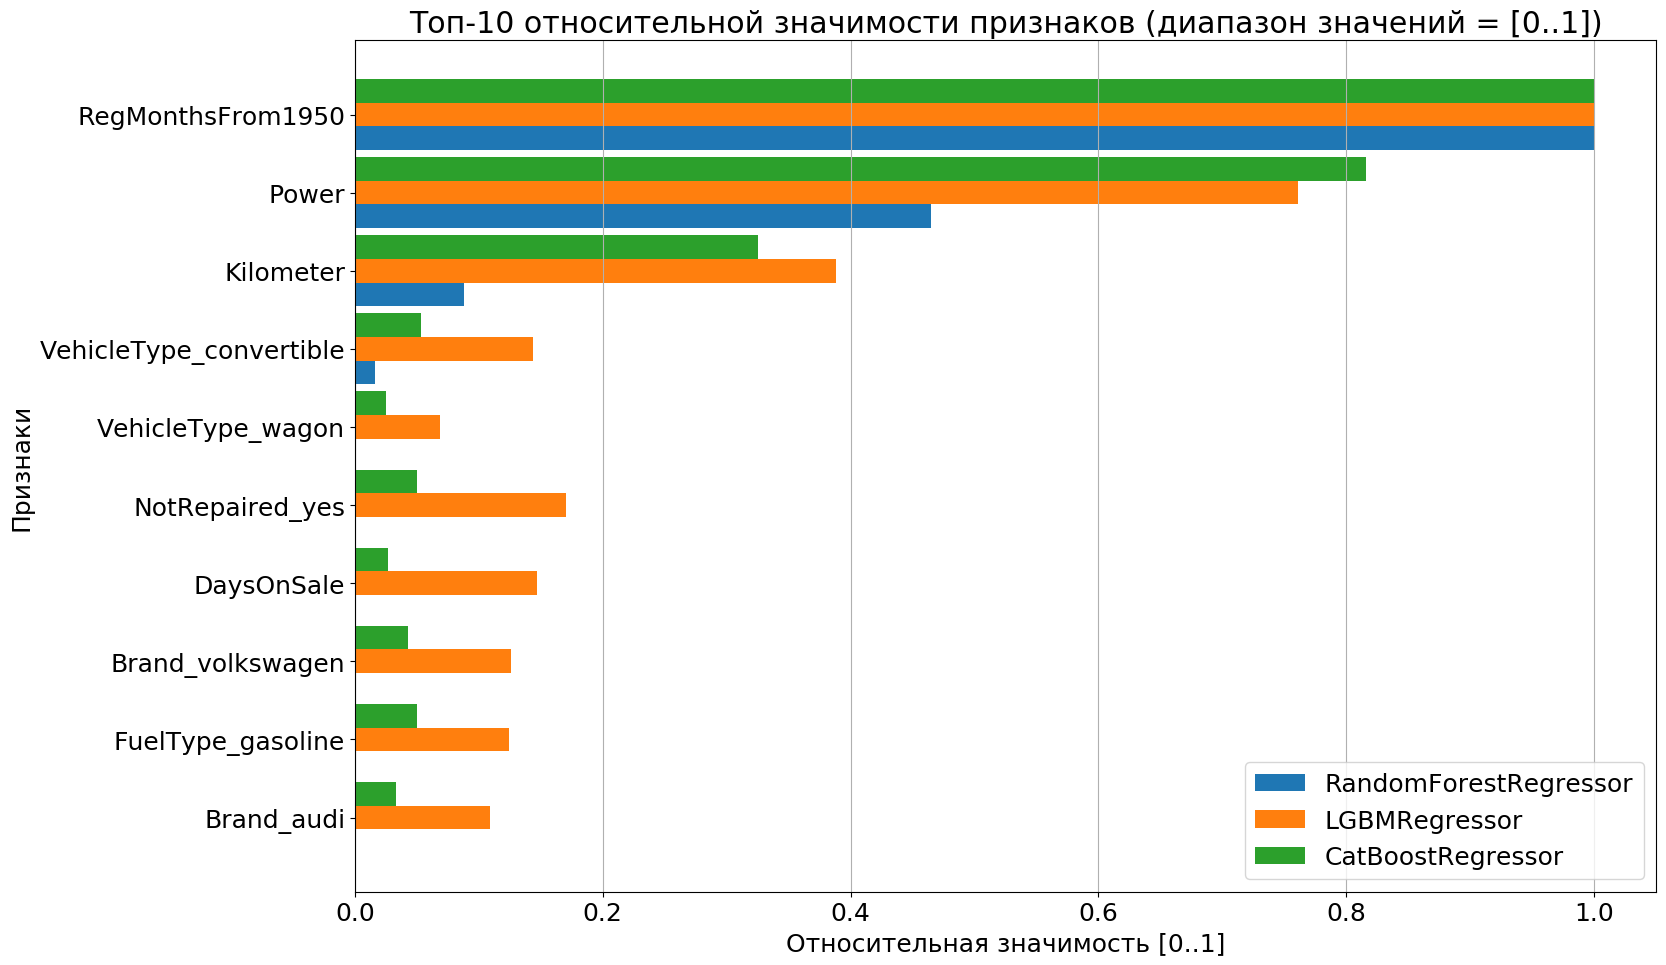

In [64]:
scaled_feature_imporances = comparator.scaled_feature_importances()
barchart(
    scaled_feature_imporances.head(10),
    ylabel='Признаки',
    xlabel='Относительная значимость [0..1]',
    title='Топ-10 относительной значимости признаков (диапазон значений = [0..1])',
    figsize=(17,10), 
    fontsize=18)

В топ-10 ожидаемо входят возраст (лидирующий), мощность двигателя, пробег. Неожиданно: значим бренд и тип кузова "кабриолет" (тут конечно надо разбираться). Полный набор данных, как мне кажется, проще смотреть напрямую:

In [65]:
scaled_feature_imporances

,RandomForestRegressor,LGBMRegressor,CatBoostRegressor
RegMonthsFrom1950,1.000,1.000,1.000
Power,0.465,0.761,0.816
Kilometer,0.088,0.388,0.325
VehicleType_convertible,0.016,0.144,0.053
VehicleType_wagon,0.001,0.069,0.025
NotRepaired_yes,0.000,0.170,0.050
DaysOnSale,0.000,0.147,0.027
Brand_volkswagen,0.000,0.126,0.043
FuelType_gasoline,0.000,0.124,0.050
Brand_audi,0.000,0.109,0.033


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей